# Libs

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
warnings.filterwarnings('ignore')


# Import

In [2]:
# Carregando o dataset com o delimitador correto
data = pd.read_csv('winequality-red.csv', delimiter=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


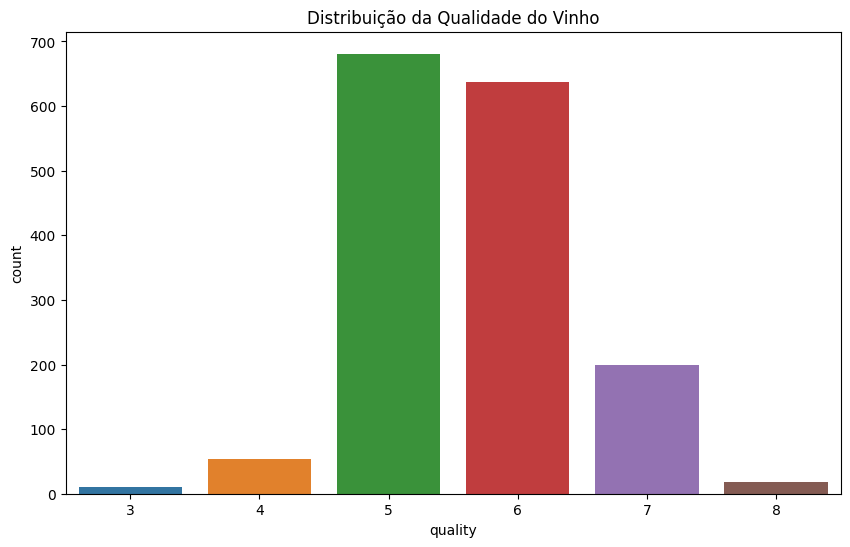

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [3]:
# Estatísticas descritivas
desc_stats = data.describe()

# Verificando valores faltantes
missing_values = data.isnull().sum()

# Distribuição da variável alvo 'quality'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='quality')
plt.title('Distribuição da Qualidade do Vinho')
plt.show()

desc_stats
missing_values

# Train Test

In [4]:
# Splitting the data into training and testing sets
X = data.drop('quality', axis=1)
y = data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Smote

In [5]:
# Applying SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Outliers

Nota: Sem a remoção de outliers as métricas de validação do modelo ficaram melhor.

In [6]:
# # Função para remover outliers usando o método IQR
# def remove_outliers(df):
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     df_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
#     return df_out

# # Removendo outliers dos dados de treinamento
# X_train_no_outliers = remove_outliers(X_train_smote)
# y_train_no_outliers = y_train_smote[X_train_no_outliers.index]

# X_train_no_outliers.shape, y_train_no_outliers.shape

# Scaler

In [7]:


# Padronizando os recursos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape

((1279, 11), (1279,))

# KNeighbors

In [8]:

# Definindo os hiperparâmetros para KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Aplicando Grid Search para KNN
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train_smote)

# Obtendo os melhores parâmetros e a melhor pontuação
knn_best_params = knn_grid.best_params_
knn_best_score = knn_grid.best_score_

knn_best_params, knn_best_score


({'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'},
 0.8505788629331189)

# cross_val_score

In [9]:
# Usando a validação cruzada com 5 divisões (folds)
scores = cross_val_score(knn_grid, X_train_scaled, y_train_smote, cv=5, scoring="accuracy")

# Mostrando os resultados
print(f"Scores da validação cruzada: {scores}")
print(f"Média da Acurácia (validação cruzada): {scores.mean() * 100:.2f}%")
print(f"Std da Acurácia (validação cruzada): {scores.std() * 100:.2f}%")


Scores da validação cruzada: [0.83685801 0.85325265 0.82753404 0.87443268 0.86081694]
Média da Acurácia (validação cruzada): 85.06%
Std da Acurácia (validação cruzada): 1.67%


# confusion_matrix

In [10]:
true_table = pd.concat([pd.DataFrame(y.to_list(), columns=['Real']), pd.DataFrame(knn_grid.predict(scaler.transform(X)), columns=['Predito'])], axis=1)

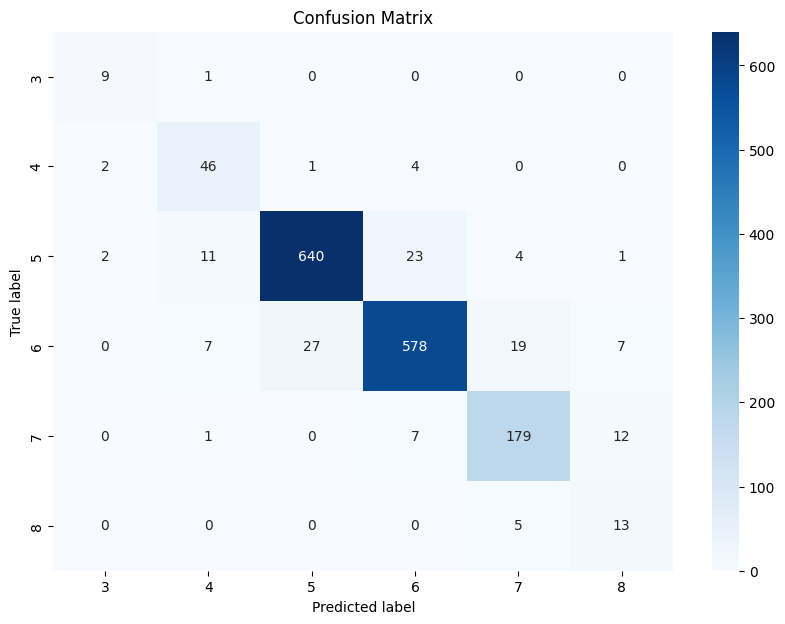

In [11]:
conf_mat = confusion_matrix(true_table['Real'], true_table['Predito'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=knn_grid.classes_, yticklabels=knn_grid.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# counter plot

In [12]:
acertos = []
ff = []
for i in true_table.index:
    f = int(round(true_table['Predito'][i],0))
    ff.append(f)
    g = int(true_table['Real'][i])
    
    if f == g:
        acertos.append(True)
    else:
        acertos.append(False)

from collections import Counter
print('Acertos: ', Counter(acertos))

Acertos:  Counter({True: 1465, False: 134})


In [13]:
actual = true_table['Real']
predicted = ff


tolerance = 0.0 
is_correct = [(abs(a - p) <= tolerance) for a, p in zip(actual, predicted)]

unique_values = list(range(3, 9)) 
true_counts = []
false_counts = []

for value in unique_values:
    indices = [i for i, a in enumerate(actual) if a == value]
    true_count = sum(1 for i in indices if is_correct[i])
    false_count = len(indices) - true_count
    true_counts.append(true_count)
    false_counts.append(false_count)

fig = go.Figure(data=[
    go.Bar(name='True', x=unique_values, y=true_counts, marker_color='green'),
    go.Bar(name='False', x=unique_values, y=false_counts, marker_color='red')
])

fig.update_layout(
    title='Acertos e Erros Para Cada Valor de Quality',
    xaxis_title='Actual Value',
    yaxis_title='Count',
    barmode='group'
)

fig.show()

# Resposta

In [14]:
true_table.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Real,5,5,5,6,5,5,5,7,7,5,5,5,5,5,5,5,7,5,4,6
Predito,5,5,5,6,5,5,5,7,7,5,5,5,5,5,5,5,7,5,4,6


In [15]:
true_table.sample(20).T

,1554,148,24,425,1017,635,995,478,988,977,77,413,1056,921,116,122,759,1267,560,1030
Real,6,6,6,7,6,5,6,5,5,5,6,7,7,6,6,5,5,6,5,7
Predito,6,6,6,7,6,5,6,5,5,5,6,7,7,6,6,5,5,6,5,7
